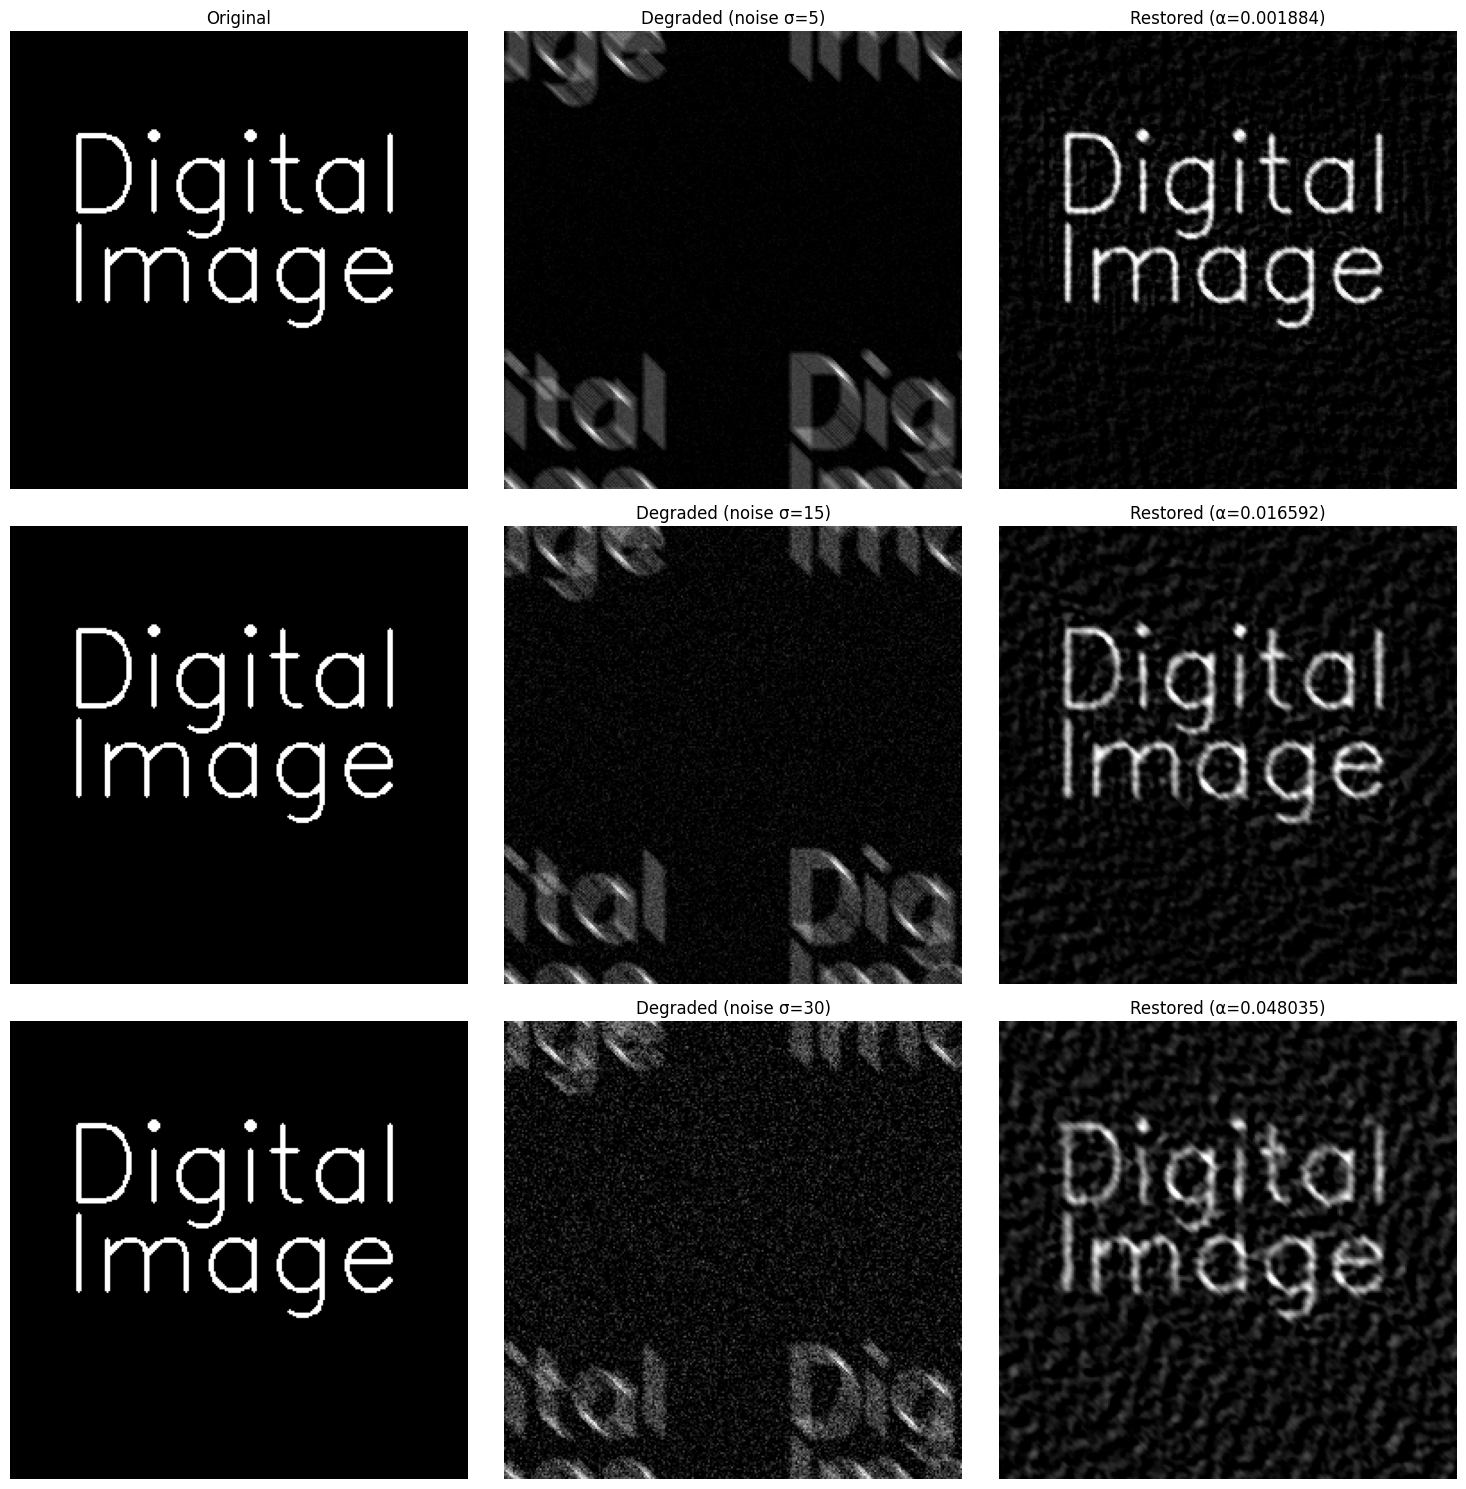

In [5]:
import numpy as np
import cv2
from scipy import optimize
import matplotlib.pyplot as plt

def create_motion_psf(shape, angle=45, motion_dist=15):
    """Create motion blur PSF."""
    psf = np.zeros(shape)
    center = (shape[0]//2, shape[1]//2)

    angle_rad = np.deg2rad(angle)
    dx = motion_dist * np.cos(angle_rad)
    dy = motion_dist * np.sin(angle_rad)

    # Create anti-aliased line
    cv2.line(psf,
             (int(center[1] - dx/2), int(center[0] - dy/2)),
             (int(center[1] + dx/2), int(center[0] + dy/2)),
             1, 1, cv2.LINE_AA)

    # Normalize PSF
    return psf / psf.sum()

def estimate_noise_power(degraded):
    """
    Estimate noise power using Laplacian operator.
    """
    # Apply Laplacian to get high-frequency components
    laplacian = cv2.Laplacian(degraded, cv2.CV_64F)

    # Use median absolute deviation for robust estimation
    mad = np.median(np.abs(laplacian - np.median(laplacian)))
    noise_std = mad / 0.6745  # Convert MAD to standard deviation

    return noise_std**2

def cls_filter(degraded, psf, alpha=None, gamma=0.1):
    """
    Improved CLS filter implementation.

    Args:
        degraded: Degraded image
        psf: Point spread function
        alpha: Regularization parameter (if None, will be estimated)
        gamma: Additional regularization factor
    """
    # Convert to float
    g = degraded.astype(float)

    # Estimate noise if alpha not provided
    if alpha is None:
        noise_power = estimate_noise_power(degraded)
        signal_power = np.var(g)
        alpha = gamma * noise_power / (signal_power + 1e-10)

    # Transform to frequency domain
    G = np.fft.fft2(g)
    H = np.fft.fft2(psf, s=g.shape)

    # Create Laplacian operator
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    P = np.fft.fft2(laplacian, s=g.shape)

    # Apply CLS filter
    H_conj = np.conjugate(H)
    H_mag_squared = np.abs(H)**2
    P_mag_squared = np.abs(P)**2

    # Improved denominator handling
    denominator = H_mag_squared + alpha * P_mag_squared
    denominator[denominator < 1e-6] = 1e-6

    F = (H_conj / denominator) * G

    # Transform back to spatial domain
    restored = np.real(np.fft.ifft2(F))

    return np.clip(restored, 0, 255).astype(np.uint8), alpha

def apply_degradation(image, psf, noise_std):
    """Apply motion blur and add noise."""
    # Apply motion blur in frequency domain
    F = np.fft.fft2(image.astype(float))
    H = np.fft.fft2(psf, s=image.shape)
    blurred = np.real(np.fft.ifft2(F * H))

    # Add noise
    noisy = blurred + np.random.normal(0, noise_std, image.shape)

    return np.clip(noisy, 0, 255).astype(np.uint8)

def demonstrate_restoration(image_size=(256, 256)):
    """Demonstrate improved restoration results."""
    # Create test image
    image = np.zeros(image_size, dtype=np.uint8)
    cv2.putText(image, 'Digital', (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)
    cv2.putText(image, 'Image', (30, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)

    # Create motion PSF
    psf = create_motion_psf(image_size, angle=45, motion_dist=15)

    # Test different noise levels
    noise_levels = [5, 15, 30]
    plt.figure(figsize=(15, 5*len(noise_levels)))

    for i, noise_std in enumerate(noise_levels):
        # Apply degradation
        degraded = apply_degradation(image, psf, noise_std)

        # Restore using improved CLS with adjusted gamma
        restored, alpha = cls_filter(degraded, psf, gamma=0.01)

        # Plot results
        plt.subplot(len(noise_levels), 3, 3*i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Original' if i == 0 else '')
        plt.axis('off')

        plt.subplot(len(noise_levels), 3, 3*i + 2)
        plt.imshow(degraded, cmap='gray')
        plt.title(f'Degraded (noise σ={noise_std})')
        plt.axis('off')

        plt.subplot(len(noise_levels), 3, 3*i + 3)
        plt.imshow(restored, cmap='gray')
        plt.title(f'Restored (α={alpha:.6f})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    demonstrate_restoration()

if __name__ == "__main__":
    main()